## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
# load in packages
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb

from pylift import TransformedOutcome
from imblearn.over_sampling import SMOTE
from itertools import combinations
from test_results import test_results, score
from statsmodels.tools import add_constant
%matplotlib inline

In [16]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


## 1. EDA

In [17]:
# check sample size
train_data.shape

(84534, 10)

In [18]:
# transfer 'Promotion' to dummy variable and describe
train_data['Promotion'] = train_data['Promotion'].map(dict(Yes=1, No=0))

# check missing value. ---No missing value
print('Missing values:', train_data.isnull().sum())

Missing values: ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64


In [69]:
# check duplicates. --- No duplicates
print('Duplicate values:', train_data.duplicated().sum())

Duplicate values: 0


In [61]:
train_data.corr()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
ID,1.000000,-0.003393,0.006902,-0.004199,-0.002757,0.003296,-0.010600,0.000133,-0.001434,0.001686
Promotion,-0.003393,1.000000,0.042884,0.005039,-0.000652,0.007269,-0.001416,-0.003552,0.001190,-0.001115
purchase,0.006902,0.042884,1.000000,-0.004906,-0.001694,-0.006395,0.032245,0.007814,-0.001538,-0.001117
V1,-0.004199,0.005039,-0.004906,1.000000,-0.001564,0.003995,0.002568,-0.001196,-0.003672,0.001436
V2,-0.002757,-0.000652,-0.001694,-0.001564,1.000000,0.001165,0.002848,-0.001046,-0.004156,-0.002293
V3,0.003296,0.007269,-0.006395,0.003995,0.001165,1.000000,0.003753,-0.001736,0.004464,0.001135
V4,-0.010600,-0.001416,0.032245,0.002568,0.002848,0.003753,1.000000,0.003161,0.002552,-0.003176
V5,0.000133,-0.003552,0.007814,-0.001196,-0.001046,-0.001736,0.003161,1.000000,-0.003043,0.003571
V6,-0.001434,0.001190,-0.001538,-0.003672,-0.004156,0.004464,0.002552,-0.003043,1.000000,-0.001398
V7,0.001686,-0.001115,-0.001117,0.001436,-0.002293,0.001135,-0.003176,0.003571,-0.001398,1.000000


1. We have no missing values and duplicated values.
2. **'ID'** is lowly correlated to all control variables, implying sample is randomly selected.
3. **'Promotion'** is lowly correlated to all control variables, implying promotion is randomly delivered

A more formal invariant metric check is included in the next part.

In [78]:
# compute pivot table
tmp = train_data[['Promotion', 'purchase', 'ID']]
df_pivot = tmp.pivot_table(index='purchase', columns='Promotion', values='ID', aggfunc='count')
df_pivot.head()

Promotion,0,1
purchase,,
0,41851,41643
1,319,721


In [84]:
df_pivot[1].sum()

42364

In [94]:
def IRR(df):
    ''' compute Incremental Response Rate (IRR)
    '''
    purch_treat = df.loc[1, 1]
    purch_ctrl = df.loc[1, 0]
    
    cust_treat = df[1].sum()
    cust_ctrl = df[0].sum()
    
    return purch_treat/cust_treat - purch_ctrl/cust_ctrl

print('The Incremental Response Rate is {:.2%}'.format(IRR(df_pivot)))

The Incremental Response Rate is 0.95%


In [95]:
def NIR(df):
    ''' Net Incremental Revenue (NIR)
    '''
    purch_treat = df.loc[1, 1]
    purch_ctrl = df.loc[1, 0]
    
    cust_treat = df[1].sum()
    
    return (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl

print('The Net Incremental Revenue is ${:.2f}'.format(NIR(df_pivot)))

The Net Incremental Revenue is $-2334.60


## 2. Metric Check: Permutation Test

For the invariant metric check, the sample size is trivial. I am going to check if all seven control variables are balanced between treatment and control group.

In [127]:
metric = train_data.groupby('Promotion').mean()
metric.drop(['ID'], axis=1, inplace=True)
metric = metric.transpose()

Text(0.5, 1.0, 'Invariant Metric Check')

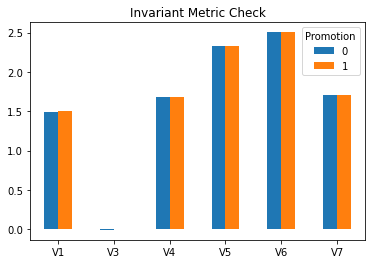

In [128]:
# drop 'V2' for better illustration. 'V2' values are much larger than all other varibales.
metric.drop(['V2','purchase'],axis=0).plot(kind='bar')
plt.xticks(rotation=0);
plt.title('Invariant Metric Check')

In [153]:
metric['obs_diff'] = metric[0] - metric[1]
metric

Promotion,0,1,obs_diff,lower bound
purchase,0.007565,0.017019,-0.009455,NaN
V1,1.496277,1.505028,-0.008751,NaN
V2,29.976876,29.970338,0.006538,NaN
V3,-0.007099,0.007446,-0.014545,NaN
V4,1.680270,1.678949,0.001321,NaN
V5,2.330638,2.324662,0.005975,NaN
V6,2.501565,2.504225,-0.002660,NaN
V7,1.702205,1.701185,0.001020,NaN


I am going to employ a permutation test to examine if these differences are significant.

In [146]:
def permu_test(df, n_trials=1000):
    '''
        Compute a confidence interval for mean using a bootstrap method.
    
    Input parameters:
        df: dataset
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        p: estimated p-value of test
    '''
    sample_diff = np.zeros([n_trials, 8])
    
    for i in range(n_trials):
        # randomly permute the grouping labels
        df.Promotion = np.random.permutation(df.Promotion)
        tmp = df.groupby('Promotion').mean()
        tmp = tmp.drop('ID', axis=1).transpose()
        sample_diff[i,:] = tmp[0] - tmp[1]
    
    lower_bound = np.percentile(sample_diff, 2.5, axis=0)
    higher_bound = np.percentile(sample_diff, 97.5, axis=0)
    
    return lower_bound, higher_bound

In [172]:
# compute the 95% confidence interval
lower_bound, higher_bound = permu_test(train_data, n_trials=10_000)

In [173]:
# concatence to the original table and determine if it is significant
metric['lower bound'] = pd.Series(lower_bound).values
metric['higher bound'] = pd.Series(higher_bound).values
metric['significance'] = 1- (metric['obs_diff']>metric['lower bound']) & (metric['obs_diff']<metric['higher bound'])
metric

Promotion,0,1,obs_diff,lower bound,higher bound,significance
purchase,0.007565,0.017019,-0.009455,-0.001458,0.001476,True
V1,1.496277,1.505028,-0.008751,-0.011827,0.011643,False
V2,29.976876,29.970338,0.006538,-0.067899,0.067915,False
V3,-0.007099,0.007446,-0.014545,-0.013054,0.013796,True
V4,1.680270,1.678949,0.001321,-0.006392,0.006337,False
V5,2.330638,2.324662,0.005975,-0.011485,0.011275,False
V6,2.501565,2.504225,-0.002660,-0.015058,0.014753,False
V7,1.702205,1.701185,0.001020,-0.006077,0.006083,False


1. All control variables except 'V3' are balanced between treatment and control group.
2. The evaluation metric 'purchase' is statically significant while lack of a practical significance.

A strict analysis should include examine exactly on 'IRR' and 'NIR'. Since this is just a demo, I will skip this part and move to logistic regression.

## 3. Logistic Regression Optimization

This part builds a logistic regression to examine the effect of each varible. It is safe touse the whole dataset since no prediction would be built on this model.

In [182]:
# use statsmodel package to run a logistic
X_log = train_data[['Promotion', 'V1','V2','V3','V4','V5','V6','V7']]
X_log = add_constant(X_log)
y_log = train_data['purchase']

logit_model = sm.Logit(y_log, X_log)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.065691
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                84534
Model:                          Logit   Df Residuals:                    84525
Method:                           MLE   Df Model:                            8
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                0.009685
Time:                        21:25:52   Log-Likelihood:                -5553.1
converged:                       True   LL-Null:                       -5607.4
Covariance Type:            nonrobust   LLR p-value:                 7.325e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6517      0.295    -19.187      0.000      -6.229      -5.074
Promotion      0.0441      0.

/Users/wenkaiwu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


1. Only 'V4' and 'V5' are significant predictors for 'purchase'.
2. 'Promotion' is really a poor predictor and far from significant.

## 4. Promotion Strategy Optimization: Uplift Model

In this part, I will use a 'pylift' package to implement a uplift model. More introductions are included [here](https://pylift.readthedocs.io/en/latest/introduction.html)

In [20]:
uplift_data = train_data.drop(['ID'], axis=1)
uplift_data.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,0,0,2,30.443518,-1.165083,1,1,3,2
1,0,0,3,32.159350,-0.645617,2,3,2,2
2,0,0,2,30.431659,0.133583,1,1,4,2
3,0,0,0,26.588914,-0.212728,2,1,4,2
4,1,0,3,28.044331,-0.385883,1,1,2,2


<AxesSubplot:xlabel='NIV', ylabel='Features'>

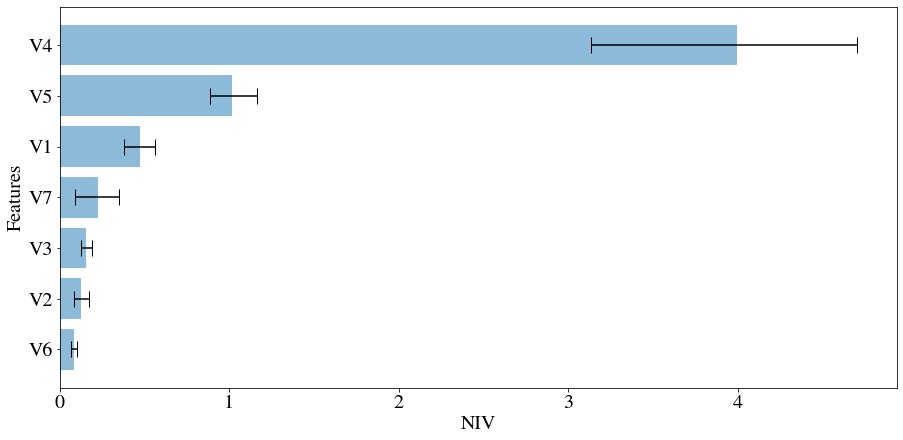

In [37]:
# plot the net information value
up = TransformedOutcome(uplift_data, col_treatment='Promotion', col_outcome='purchase', stratify=uplift_data['purchase'])
up.NIV()


This measure shows the relative strength of the relationship of each feature to the target. Again, 'V4' and 'V5' are most correlated. 

In [42]:
# grid search for hypterparameter tuning
up.randomized_search(n_iter=5, random_state=1)
up.fit(**up.rand_search_.best_params_)

0.0014009223594990492


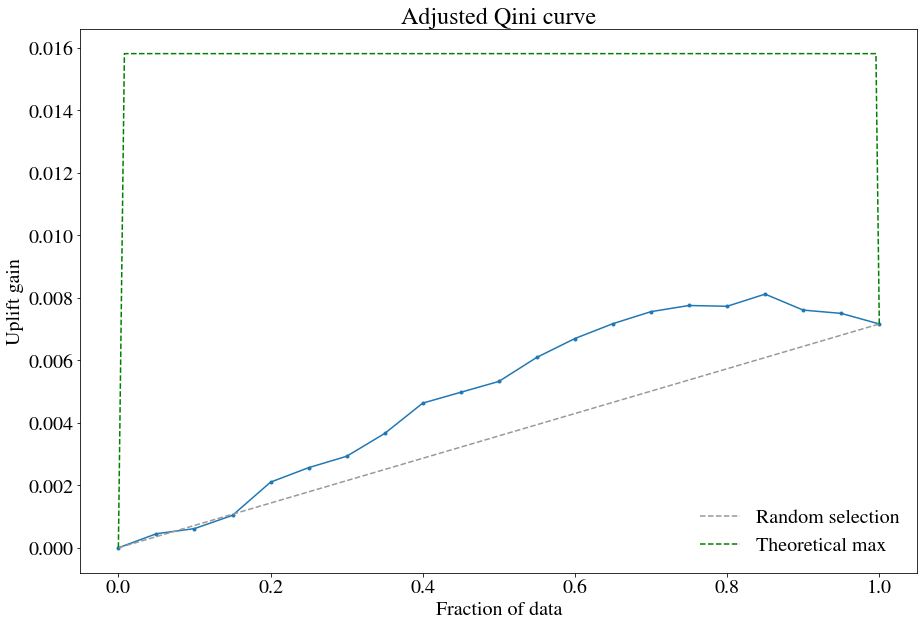

In [44]:
# plot the adjusted Qini curve
up.plot(plot_type='aqini', show_theoretical_max=True)
print(up.test_results_.Q_aqini)

It can be seen that our model is better than random choice but much worse than the practical/theoretical maximum possible.

In [117]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = []
    lift = up.model.predict(df)
    
    for val in lift:
        if val >= 0.01:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
   
    return promotion

In [118]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0142.

Your nir with this strategy is -107.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.014230848721208628, -107.90000000000009)